### Analysis of time lags involved in the ~ongoing~ DRC EBOV outbreak

Including potential biases of sequencing with respect to location (Health Zone) and time.

Author [James Hadfield](https://twitter.com/hamesjadfield)

Date: Feb 2020
(Revised: August 2020)

In [6]:
## Set up cell, including some helpful imports functions etc. Thanks to Gytis for MPL help

%reset -f

from datetime import datetime
from collections import defaultdict
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon, PathPatch, Patch
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats


def ambiguous_date_to_date_range(mydate, fmt):
    sep = fmt.split('%')[1][-1]
    min_date, max_date = {}, {}
    today = datetime.today().date()

    for val, field  in zip(mydate.split(sep), fmt.split(sep+'%')):
        f = 'year' if 'y' in field.lower() else ('day' if 'd' in field.lower() else 'month')
        if 'XX' in val:
            if f=='year':
                return None, None
            elif f=='month':
                min_date[f]=1
                max_date[f]=12
            elif f=='day':
                min_date[f]=1
                max_date[f]=31
        else:
            min_date[f]=int(val)
            max_date[f]=int(val)
    max_date['day'] = min(max_date['day'], 31 if max_date['month'] in [1,3,5,7,8,10,12]
                                           else 28 if max_date['month']==2 else 30)
    lower_bound = datetime(year=min_date['year'], month=min_date['month'], day=min_date['day']).date()
    upper_bound = datetime(year=max_date['year'], month=max_date['month'], day=max_date['day']).date()
    return (lower_bound, upper_bound if upper_bound<today else today)

def numeric_date(dt_string):
    if not dt_string or dt_string=="None" or dt_string == 'XXXX-XX-XX':
        return None
    from calendar import isleap

    if 'XX' in dt_string:
        ambig_date = ambiguous_date_to_date_range(dt_string, "%Y-%m-%d")
        return (numeric_date(str(ambig_date[0]))+numeric_date(str(ambig_date[1])))/2;
    else:
        dt = datetime.strptime(dt_string, "%Y-%m-%d")
    days_in_year = 366 if isleap(dt.year) else 365
    try:
        res = dt.year + (dt.timetuple().tm_yday-0.5) / days_in_year
    except:
        res = None
    return res

### Import metadata reflecting strains (samples) used in manuscript dataset




In [7]:
## IMPORT METADATA 
import csv
import re

dropped_strains = set(['MK007329.1'])
data = []

with open("../config/dropped_strains.txt") as fh:
    for line in fh:
        dropped_strains.add(line.split("#")[0].strip())

        
with open("../data/metadata.tsv") as fh:
    _strains_seen = set()
    for row in csv.DictReader(fh, delimiter='\t'):
        strain = row['strain']
        if strain in dropped_strains:
            continue
        if strain in _strains_seen:
            print("PROBLEM")
        _strains_seen.add(strain)
        data.append({
            "name": strain,
            "sample_date": row['date'],
            "sequenced": row['date_seq'],
            "hz": row['health_zone']
        })
for d in data[0:3]:
    print(d)
print("...")
print("{} strains for analysis".format(len(data)))
assert(len(data)==792) ## manuscript version has n=792
del row, fh, line, d, _strains_seen, strain, dropped_strains

{'name': '18FHV089', 'sample_date': '2018-07-27', 'sequenced': '2018-08-05', 'hz': 'Mabalako'}
{'name': '18FHV090', 'sample_date': '2018-07-28', 'sequenced': '2018-08-05', 'hz': 'Mabalako'}
{'name': 'BEN018', 'sample_date': '2018-08-03', 'sequenced': '2018-10-12', 'hz': 'Mabalako'}
...
792 strains for analysis


## Scan private (credentialed) datasets & hap-maps to get release-data of isolates

We publish private analyses (authentication-needed to be viewable on nextstrain.org) as part of our effort to help the outbreak response.
Prior to the setting-up of nextstrain (and ongoing) were manual hap-map creation and dissemination via email.

This cell analyses these to parse the release-date (for use by the outbreak response team) of each sample.

This cell requires private datasets to be located in `./private_datasets` which is gitignored for obvious reasons.
They can be fetched via `nextstrain remote download -r s3://nextstrain-inrb` (credentials needed!). 
The CSV detailing release date of hap-map (haplotype maps) was generated via the `hap-map-parser.ipynb` notebook however the hap-maps themselves are private


In [8]:
import json
import sys

def collect_strains_in_tree(tree):
    name_regex = r'lab-([-A-Za-z0-9]+)(_epi-([-A-Za-z0-9]+))?$'
    strains = []
    def _recurse(node):
        if not "children" in node:
            ## the name used in private datasets was sometimes of the form
            ## lab-LABID_epi-EPIID. If this is the case we only use the LABID
            ## which is consistent with the public data naming scheme
            m = re.match(name_regex, node['strain'])
            if m:
                strains.append(m.groups()[0])
            else:
                strains.append(node["strain"])
        else:
            for child in node["children"]:
                _recurse(child)
    _recurse(tree)
    return strains


def parse_private_jsons():
    from os import listdir
    from os.path import isfile, join
    subdir = "./private_datasets"
    filenames = [join(subdir, f) for f in listdir(subdir) if isfile(join(subdir, f)) and f.endswith("_tree.json") and not "equateur" in f]
    filenames.sort(key=lambda f: numeric_date(re.search(r"(\d{4}-\d{2}-\d{2})", f).groups()[0]))
    
    private_release_dates = {}
    
    for fn in filenames:
        with open(fn) as fh:
            release_date = re.search(r"(\d{4}-\d{2}-\d{2})", fn).groups()[0]
            json_data = json.load(fh)
            strains = collect_strains_in_tree(json_data)
            for strain in [s for s in strains]:
                if strain not in private_release_dates:
                    private_release_dates[strain] = release_date
#             print(fn, "//", release_date, "// total:", len(private_release_dates.keys()))
            
    for d in data:
        d["private_nextstrain_release"] = private_release_dates.get(d["name"], None)
    
    print(f"Parsed {len(filenames)} private nextstrain JSONs and extracted dates for {len(private_release_dates.keys())} strains")

def parse_hap_map_release_dates():
    hmd = {}
    with open("./private_datasets/hap_map_dates.csv") as fh:
        for row in csv.DictReader(fh, delimiter=','):
            hmd[row["lab_id"]] = row["date"]

    for d in data:
        d["hap_map_release"] = hmd.get(d["name"], None)
        
    print(f"Parsed dates for {len(hmd.keys())} strains from hap-maps")


parse_private_jsons()
parse_hap_map_release_dates()

Parsed 36 private nextstrain JSONs and extracted dates for 812 strains
Parsed dates for 342 strains from hap-maps


## Scan publicly released Nextstrain datasets

These were stored on GitHub for dissemination via nextstrain.org/community/inrb-drc/ebola-nord-kivu.
Since we overwrote the file on each update, we have to go back and parse the Git history to get the required information.


#### Get all released public dataset files

1. Change to the directory where you have the github.com/inrb-drc/ebola-nord-kivu repo
2. Store the output directory in the `${PUBIC_DATASET_SAVE_DIR}`. This should be `./public_datasets` relative to this notebook.
3. Commits which have modified the file:

```bash
for c in $(git log --all auspice/ebola-nord-kivu_tree.json | grep "commit" | cut -d ' ' -f 2); do
    d=$(git show --no-patch --no-notes --pretty='%ai' $c | cut -d ' ' -f 1)
    git show ${c}:auspice/ebola-nord-kivu_tree.json > ${PUBIC_DATASET_SAVE_DIR}/ebola-nord-kivu_tree_${c}_${d}.json;
done;
```


#### Loop through these files (similar to above) to identify when strains were first released

Note that for the public releases, the strain name is the lab ID



In [9]:
def parse_public_jsons():
    from os import listdir
    from os.path import isfile, join
    subdir = "./public_datasets"
    filenames = [join(subdir, f) for f in listdir(subdir) if isfile(join(subdir, f)) and f.endswith(".json")]    
    filenames.sort(key=lambda f: numeric_date(re.search(r"(\d{4}-\d{2}-\d{2})", f).groups()[0]))
    
    public_release_dates = {}
    
    for fn in filenames:
        with open(fn) as fh:
            release_date = re.search(r"(\d{4}-\d{2}-\d{2})", fn).groups()[0]
            json_data = json.load(fh)
            strains = collect_strains_in_tree(json_data)
            for strain in [s for s in strains]:
                if strain not in public_release_dates:
                    public_release_dates[strain] = release_date
#             print(fn, "//", release_date, "// total:", len(public_release_dates.keys()))
            
    for d in data:
        d["public_nextstrain_release"] = public_release_dates.get(d["name"], None)
    
    print(f"Parsed {len(filenames)} public nextstrain JSONs and extracted dates for {len(public_release_dates.keys())} strains")
    assert(len(filenames) == 22)
    
parse_public_jsons()

Parsed 22 public nextstrain JSONs and extracted dates for 759 strains


## Summary of data so far:

* Strain name (Lab ID)
* sample date
* sequencing date
* hap-map release date (if applicable, else `None`)
* private nextstrain release date (if applicable, else `None`)
* public nextstrain release date (if applicable, else `None`)

We now convert date data (so far in YYYY-MM-DD) format to a numerical form, and sort chronologically

In [10]:
for d in data:
    d["sample_date_num"] = numeric_date(d.get("sample_date", None))
    d["sequenced_num"] = numeric_date(d.get("sequenced", None))
    d["hap_map_release_num"] = numeric_date(d.get("hap_map_release", None))
    d["public_nextstrain_release_num"] = numeric_date(d.get("public_nextstrain_release", None))
    d["private_nextstrain_release_num"] = numeric_date(d.get("private_nextstrain_release", None))
    
def get_key(d):
    if d["sample_date"]: return d["sample_date_num"]
    print("SORTING ERROR -- missing sample_date_num", d)

print("First genome:", data[0])
print()
print("Last genome:", data[-1])
    
data.sort(key=get_key)
del d, get_key

First genome: {'name': '18FHV089', 'sample_date': '2018-07-27', 'sequenced': '2018-08-05', 'hz': 'Mabalako', 'private_nextstrain_release': '2019-09-13', 'hap_map_release': '2018-11-20', 'public_nextstrain_release': '2019-03-04', 'sample_date_num': 2018.5684931506848, 'sequenced_num': 2018.5931506849315, 'hap_map_release_num': 2018.886301369863, 'public_nextstrain_release_num': 2019.1712328767123, 'private_nextstrain_release_num': 2019.7}

Last genome: {'name': 'MAN9840', 'sample_date': '2019-XX-XX', 'sequenced': '2019-12-19', 'hz': '?', 'private_nextstrain_release': '2020-01-12', 'hap_map_release': None, 'public_nextstrain_release': '2020-01-29', 'sample_date_num': 2019.5, 'sequenced_num': 2019.9657534246576, 'hap_map_release_num': None, 'public_nextstrain_release_num': 2020.077868852459, 'private_nextstrain_release_num': 2020.0314207650274}


# Plot scatter of temporal events

Main axis bounds: 2018.5684931506848 2020.5505464480875


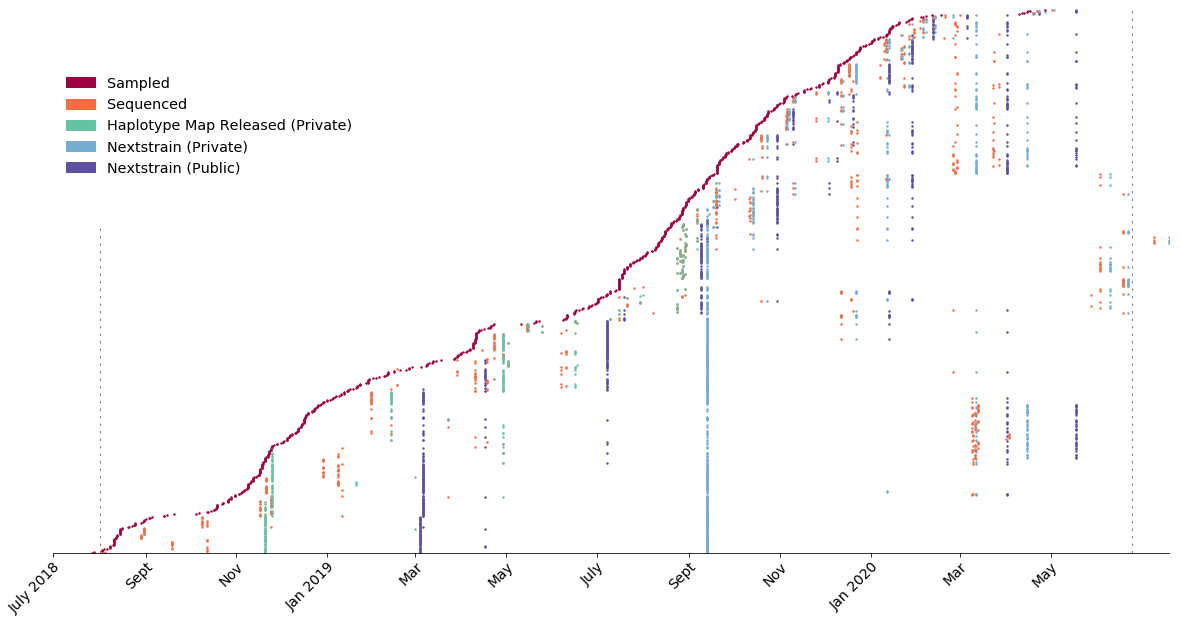

In [11]:
def draw_temporal_scatter(ax):
    
    variables = [
        {"key": "sample_date_num",                "label": "Sampled",       "colour": "#9e0142", },
        {"key": "sequenced_num",                  "label": "Sequenced",     "colour": "#f46d43"},
        {"key": "hap_map_release_num",            "label": "Haplotype Map Released (Private)",   "colour": "#66c2a5"},
        {"key": "private_nextstrain_release_num", "label": "Nextstrain (Private)", "colour": "#74add1"},
        {"key": "public_nextstrain_release_num",  "label": "Nextstrain (Public)", "colour": "#5e4fa2"}
    ]
    min_date = 3000; max_date = 1000;
    for d in data:
        for v in variables:
            if not d[v['key']]: continue
            if d[v['key']] > max_date: max_date = d[v['key']];
            if d[v['key']] < min_date: min_date = d[v['key']];
    print("Main axis bounds:", min_date, max_date)
    
    ax.set_ylim(0, len(data))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(min_date, max_date)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for idx, d in enumerate(data):
        for v in variables:
            if d[v["key"]]:
                ax.scatter(d[v["key"]], idx, s=2, c=v["colour"])
                
    # x-axis ticks / labels somewhat harcoded
    xlabs = [
        [numeric_date("2018-07-01"), "July 2018"],
        [numeric_date("2018-09-01"), "Sept"],
        [numeric_date("2018-11-01"), "Nov"],
        [numeric_date("2019-01-01"), "Jan 2019"],
        [numeric_date("2019-03-01"), "Mar"],
        [numeric_date("2019-05-01"), "May"],
        [numeric_date("2019-07-01"), "July"],
        [numeric_date("2019-09-01"), "Sept"],
        [numeric_date("2019-11-01"), "Nov"],
        [numeric_date("2020-01-01"), "Jan 2020"],
        [numeric_date("2020-03-01"), "Mar"],
        [numeric_date("2020-05-01"), "May"]
    ]
    ax.set_xticks(np.array([x[0] for x in xlabs]))
    ax.set_xticklabels(np.array([x[1] for x in xlabs]), fontsize=14, rotation=45, ha="right", rotation_mode="anchor")

    ax.legend(
        handles=[Patch(color=v["colour"], label=v["label"]) for v in variables],
        loc='upper left', bbox_to_anchor=(0, 0.9), fontsize="x-large", frameon=False
    )
    
    # vertical lines for start & end of outbreak
    ax.axvline(numeric_date("2018-08-01"), dashes=(5,10), color='k', lw=0.5, ymax=0.6)
    ax.axvline(numeric_date("2020-06-25"), dashes=(5,10), color='k', lw=0.5)

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
fig, ax = plt.subplots(figsize=(20, 10))
draw_temporal_scatter(ax)


## To examine the relationship between case counts and genomic data we need both case count data (via WHO) and to parse the metadata...


## Source of Cases per WHO epi-week

Initially taken from http://who.maps.arcgis.com/apps/opsdashboard/index.html#/e70c3804f6044652bc37cce7d8fcef6c Feb 20 2019 but this now (August 2020) requires a password.

Subsequently used the the published WHO epi reports to check things.
The reporting dates often don't quite match epi weeks, so instead of reporting epi weeks i'm going to be explicit about the reporting periods.

Note that this lumped a the first 16 confirmed cases into a single report.


## Source of Cases per HZ

WHO External Situation Report 98.
Date of issue: 23 June 2020.
Data as reported by: 21 June 2020.
I use probable and confirmed together ("total cases" column) so that the total sums to 3470, which is the total number of cases in the outbreak.

_Note that we had at least one sequence from every single HZ with cases :)_


## WHO Epi weeks
The WHO defines epidemiological weeks as starting on a Monday and ending on a Sunday. The CDC defines epidemiological weeks as starting on a Sunday and ending on a Saturday. In either case, the end of the first epidemiological week of the year by definition must fall at least four days into the year. In other words, the first epidemiological week always begins on a date between December 29 and January 4. 
_Update: going to be explicit about reporting period of each sit rep_


In [12]:
true_total = 3470 # includes probable and confirmed

case_counts_per_sit_rep = [    
    {         'sit_rep': False, 'total_confirmed': 0, 'last_day': '2018-07-15'}, # Placeholder. Last day means last day before potential first case!
    # WHO notified on 1 August 2018. Mid-late July was when the fevers began.
    {'new_cases': 16, 'sit_rep': 1, 'total_confirmed': 16, 'last_day': '2018-08-05'}, # FIRST SIT REP. 16 confirmed, 27 probably, 34 deaths (7 confirmed as EBOV). 
    {'new_cases': 14, 'sit_rep': 2, 'total_confirmed': 30, 'last_day': '2018-08-12'},
    {'new_cases': 45, 'sit_rep': 3, 'total_confirmed': 75, 'last_day': '2018-08-20'}, # reports data up until 20th august, even though that's technically epi week 34
    {'new_cases': 9,  'sit_rep': 4, 'total_confirmed': 83, 'last_day': '2018-08-26'}, # back to proper epi weeks. 
        # PROBLEM! 2018W34, sit rep #4, reports 9 new but 83 total. That doesn't match up with prev report (75+9 != 83).
    {'new_cases': 8,  'sit_rep': 5, 'total_confirmed': 91, 'last_day': '2018-09-02'},
    {'new_cases': 10, 'sit_rep': 6, 'total_confirmed': 101, 'last_day': '2018-09-09'}, # don't actually say how many confirmed. Inferred via comparison with prev week
    {'new_cases': 10, 'sit_rep': 7, 'total_confirmed': 111, 'last_day': '2018-09-16'},
    {'new_cases': 8,  'sit_rep': 8, 'total_confirmed': 119, 'last_day': '2018-09-23'},
    {'new_cases': 12, 'sit_rep': 9, 'total_confirmed': 130, 'last_day': '2018-10-02'}, # not a true epi week. 12 new cases should give 131 not 130.
    {'new_cases': 19, 'sit_rep': 10, 'total_confirmed': 146, 'last_day': '2018-10-07'}, # back to proper epi weeks. data doesn't add up...
    {'new_cases': 35, 'sit_rep': 11, 'total_confirmed': 181, 'last_day': '2018-10-15'}, # not a proper epi week
    {'new_cases': 22, 'sit_rep': 12, 'total_confirmed': 203, 'last_day': '2018-10-21'},
    {'new_cases': 36, 'sit_rep': 13, 'total_confirmed': 239, 'last_day': '2018-10-28'},
    {'new_cases': 26, 'sit_rep': 14, 'total_confirmed': 265, 'last_day': '2018-11-05'},
        # Sit rep 15 is different -- it does reflect an epi-week (clearly states 5-11 nov, which is week 45), but also  adds in historical (probable) cases etc
        # We use its data here as it is more authorative than previous sit-reps. Despite this, the numbers still don't add up.
    {'new_cases': 31, 'sit_rep': 15, 'total_confirmed': 295, 'last_day': '2018-11-11'},
    {'new_cases': 40, 'sit_rep': 16, 'total_confirmed': 326, 'last_day': '2018-11-19'}, # not a proper epi week.
    {'new_cases': 48, 'sit_rep': 17, 'total_confirmed': 374, 'last_day': '2018-11-26'}, # not a proper epi week
    {'new_cases': 31, 'sit_rep': 18, 'total_confirmed': 405, 'last_day': '2018-12-03'},
    {'new_cases': 39, 'sit_rep': 19, 'total_confirmed': 452, 'last_day': '2018-12-10'}, # doesn't add up
    {'new_cases': 39, 'sit_rep': 20, 'total_confirmed': 491, 'last_day': '2018-12-16'},
    {'new_cases': 46, 'sit_rep': 21, 'total_confirmed': 537, 'last_day': '2018-12-25'}, # not an epi week
    {'new_cases': 23, 'sit_rep': 22, 'total_confirmed': 560, 'last_day': '2019-01-01'}, # not an epi week.
    {'new_cases': 17, 'sit_rep': 23, 'total_confirmed': 577, 'last_day': '2019-01-06'}, # not an epi week
    {'new_cases': 32, 'sit_rep': 24, 'total_confirmed': 609, 'last_day': '2019-01-14'},
    {'new_cases': 41, 'sit_rep': 25, 'total_confirmed': 650, 'last_day': '2019-01-21'},
    {'new_cases': 44, 'sit_rep': 26, 'total_confirmed': 689, 'last_day': '2019-01-28'},
    {'new_cases': 42, 'sit_rep': 27, 'total_confirmed': 731, 'last_day': '2019-02-03'},
    {'new_cases': 24, 'sit_rep': 28, 'total_confirmed': 755, 'last_day': '2019-02-10'},
    {'new_cases': 20, 'sit_rep': 29, 'total_confirmed': 775, 'last_day': '2019-02-17'},
    {'new_cases': 32, 'sit_rep': 30, 'total_confirmed': 807, 'last_day': '2019-02-24'},
    {'new_cases': 25, 'sit_rep': 31, 'total_confirmed': 832, 'last_day': '2019-03-03'},
    {                 'sit_rep': 32, 'total_confirmed': 858, 'last_day': '2019-03-10'}, # doesn't even say how many newly confirmed this week. Crazy.
    {                 'sit_rep': 33, 'total_confirmed': 895, 'last_day': '2019-03-17'}, # doesn't even say how many newly confirmed this week. Crazy.
    {                 'sit_rep': 34, 'total_confirmed': 951, 'last_day': '2019-03-24'},
    {'new_cases': 72, 'sit_rep': 35, 'total_confirmed': 1023, 'last_day': '2019-03-31'},
    {'new_cases': 65, 'sit_rep': 36, 'total_confirmed': 1088, 'last_day': '2019-04-07'},
    {'new_cases': 110,'sit_rep': 37, 'total_confirmed': 1198, 'last_day': '2019-04-14'},
    {'new_cases': 80, 'sit_rep': 38, 'total_confirmed': 1287, 'last_day': '2019-04-22'},
    {'new_cases': 126,'sit_rep': 39, 'total_confirmed': 1400, 'last_day': '2019-04-28'},
    {'new_cases': 106,'sit_rep': 40, 'total_confirmed': 1506, 'last_day': '2019-05-05'},
    {'new_cases': 110,'sit_rep': 41, 'total_confirmed': 1617, 'last_day': '2019-05-12'},
    {'new_cases': 121,'sit_rep': 42, 'total_confirmed': 1738, 'last_day': '2019-05-19'},
    {'new_cases': 88, 'sit_rep': 43, 'total_confirmed': 1826, 'last_day': '2019-05-26'},
    {'new_cases': 88, 'sit_rep': 44, 'total_confirmed': 1914, 'last_day': '2019-06-02'},
    # Sit rep 45 includes UGANDA (n=3 cases). These aren't part of the 1977 total and are not counted in upcoming sit-reps, which are only about the DRC
    {'new_cases': 54, 'sit_rep': 45, 'total_confirmed': 1977, 'last_day': '2019-06-12', 'uganda_cases': 3},
    {                 'sit_rep': 46, 'total_confirmed': 2074, 'last_day': '2019-06-16'},
    {                 'sit_rep': 47, 'total_confirmed': 2153, 'last_day': '2019-06-23'},
    {                 'sit_rep': 48, 'total_confirmed': 2244, 'last_day': '2019-06-30'},
    {                 'sit_rep': 49, 'total_confirmed': 2324, 'last_day': '2019-07-07'},
    {                 'sit_rep': 50, 'total_confirmed': 2407, 'last_day': '2019-07-14'},
    {                 'sit_rep': 51, 'total_confirmed': 2498, 'last_day': '2019-07-21'},
    {                 'sit_rep': 52, 'total_confirmed': 2577, 'last_day': '2019-07-28'},
    {'new_cases': 92, 'sit_rep': 53, 'total_confirmed': 2669, 'last_day': '2019-08-04'},
    {'new_cases': 68, 'sit_rep': 54, 'total_confirmed': 2737, 'last_day': '2019-08-11'},
    {'new_cases': 57, 'sit_rep': 55, 'total_confirmed': 2794, 'last_day': '2019-08-18'},
    ## SIT REP 56 IS MISSING (404 on WHO PAGE!) -> Inferred its data by using the new_cases either side. The dates match WHO epi weeks here.
    {'new_cases': 78, 'sit_rep': False, 'total_confirmed': 2872, 'last_day': '2019-08-25'},
    {'new_cases': 59, 'sit_rep': 57, 'total_confirmed': 2931, 'last_day': '2019-09-01'},
    {'new_cases': 45, 'sit_rep': 58, 'total_confirmed': 2970, 'last_day': '2019-09-08'},
    {'new_cases': 51, 'sit_rep': 59, 'total_confirmed': 3018, 'last_day': '2019-09-15'},
    {'new_cases': 39, 'sit_rep': 60, 'total_confirmed': 3057, 'last_day': '2019-09-22'},
    {'new_cases': 30, 'sit_rep': 61, 'total_confirmed': 3077, 'last_day': '2019-09-29'},
    {'new_cases': 14, 'sit_rep': 62, 'total_confirmed': 3091, 'last_day': '2019-10-06'},
    {'new_cases': 15, 'sit_rep': 63, 'total_confirmed': 3106, 'last_day': '2019-10-13'},
    {'new_cases': 21, 'sit_rep': 64, 'total_confirmed': 3127, 'last_day': '2019-10-20'},
    {'new_cases': 20, 'sit_rep': 65, 'total_confirmed': 3147, 'last_day': '2019-10-27'},
    {'new_cases': 10, 'sit_rep': 66, 'total_confirmed': 3157, 'last_day': '2019-11-03'},
    {'new_cases': 12, 'sit_rep': 67, 'total_confirmed': 3169, 'last_day': '2019-11-12'},
    {'new_cases': 9,  'sit_rep': 68, 'total_confirmed': 3178, 'last_day': '2019-11-17'},
    {'new_cases': 7,  'sit_rep': 69, 'total_confirmed': 3185, 'last_day': '2019-11-24'},
    {'new_cases': 10, 'sit_rep': 70, 'total_confirmed': 3195, 'last_day': '2019-12-01'},
    {'new_cases': 11, 'sit_rep': 71, 'total_confirmed': 3206, 'last_day': '2019-12-08'},
    {'new_cases': 24, 'sit_rep': 72, 'total_confirmed': 3230, 'last_day': '2019-12-15'},
    {'new_cases': 14, 'sit_rep': 73, 'total_confirmed': 3244, 'last_day': '2019-12-22'},
    {'new_cases': 28, 'sit_rep': 74, 'total_confirmed': 3272, 'last_day': '2020-01-05'},
    {'new_cases': 8,  'sit_rep': 75, 'total_confirmed': 3280, 'last_day': '2020-01-12'},
    {'new_cases': 15, 'sit_rep': 76, 'total_confirmed': 3295, 'last_day': '2020-01-19'},
    {'new_cases': 4, 'sit_rep': 77, 'total_confirmed': 3299, 'last_day': '2020-01-26'},
    {'new_cases': 6, 'sit_rep': 78, 'total_confirmed': 3305, 'last_day': '2020-02-02'},
    {'new_cases': 3, 'sit_rep': 79, 'total_confirmed': 3308, 'last_day': '2020-02-09'},
    {'new_cases': 1, 'sit_rep': 80, 'total_confirmed': 3309, 'last_day': '2020-02-16'},
    {'new_cases': 1, 'sit_rep': 81, 'total_confirmed': 3310, 'last_day': '2020-02-23'},
    {'new_cases': 0, 'sit_rep': 82, 'total_confirmed': 3310, 'last_day': '2020-03-01'},
    {'new_cases': 0, 'sit_rep': 83, 'total_confirmed': 3310, 'last_day': '2020-03-08'},
    {'new_cases': 0, 'sit_rep': 84, 'total_confirmed': 3310, 'last_day': '2020-03-15'}, # There have been no new cases of Ebola virus disease (EVD) reported since 17 February 2020
    {'new_cases': 0, 'sit_rep': 85, 'total_confirmed': 3310, 'last_day': '2020-03-22'}, # There have been no new cases of Ebola virus disease (EVD) reported since 17 February 2020
    {'new_cases': 0, 'sit_rep': 86, 'total_confirmed': 3310, 'last_day': '2020-03-29'}, # There have been no new cases of Ebola virus disease (EVD) reported since 17 February 2020
    {'new_cases': 0, 'sit_rep': 87, 'total_confirmed': 3310, 'last_day': '2020-04-05'}, # There have been no new cases of Ebola virus disease (EVD) reported since 17 February 2020
    {'new_cases': 2, 'sit_rep': 88, 'total_confirmed': 3312, 'last_day': '2020-04-12'},
    {'new_cases': 4, 'sit_rep': 89, 'total_confirmed': 3316, 'last_day': '2020-04-19'}, 
    {'new_cases': 0, 'sit_rep': 90, 'total_confirmed': 3316, 'last_day': '2020-04-26'}, 
    {'new_cases': 1, 'sit_rep': 91, 'total_confirmed': 3317, 'last_day': '2020-05-05'}, 
    {'new_cases': 0, 'sit_rep': 92, 'total_confirmed': 3317, 'last_day': '2020-05-10'}, 
    {'new_cases': 0, 'sit_rep': 93, 'total_confirmed': 3317, 'last_day': '2020-05-17'},
    {'new_cases': 0, 'sit_rep': 94, 'total_confirmed': 3317, 'last_day': '2020-05-24'},
    {'new_cases': 0, 'sit_rep': 95, 'total_confirmed': 3317, 'last_day': '2020-05-31'}, # no confirmed cases, 
    {'new_cases': 0, 'sit_rep': 96, 'total_confirmed': 3317, 'last_day': '2020-06-08'},
    {'new_cases': 0, 'sit_rep': 97, 'total_confirmed': 3317, 'last_day': '2020-06-14'},
    {'new_cases': 0, 'sit_rep': 98, 'total_confirmed': 3317, 'last_day': '2020-06-21'} # Sit rep 98 was when the outbreak was declared over!!!
]


def summarise_situation_reports():
    case_counts_per_sit_rep[0]['n_inferred'] = 0
    for idx in range(1, len(case_counts_per_sit_rep)):
        new_cases = case_counts_per_sit_rep[idx]['total_confirmed'] - case_counts_per_sit_rep[idx-1]['total_confirmed']
        if new_cases<0:
            print(f"PROBLEM -- cases dropped from sit-rep {case_counts_per_sit_rep[idx-1]['sit_rep']} -> {case_counts_per_sit_rep[idx]['sit_rep']}")
        assert(numeric_date(case_counts_per_sit_rep[idx]['last_day']) > numeric_date(case_counts_per_sit_rep[idx-1]['last_day']))
        if idx!=1 and case_counts_per_sit_rep[idx]['sit_rep']!=(case_counts_per_sit_rep[idx-1]['sit_rep']+1):
            print(f"Sit-rep missing? {case_counts_per_sit_rep[idx-1]['sit_rep']} -> {case_counts_per_sit_rep[idx]['sit_rep']}")
        case_counts_per_sit_rep[idx]['n_inferred'] = new_cases
        if 'new_cases' in case_counts_per_sit_rep[idx]:
            if case_counts_per_sit_rep[idx]['new_cases'] != new_cases:
                print(f"Sit-rep {str(case_counts_per_sit_rep[idx]['sit_rep'])} reported {str(case_counts_per_sit_rep[idx]['new_cases'])} cases but the total increased by {str(new_cases)}")
        else:
            print(f"Sit-rep {str(case_counts_per_sit_rep[idx]['sit_rep'])} was missing number of new cases. We infer {str(new_cases)}")

            
def add_samples_to_case_counts():
    # for each (sequenced) sample, find out what sit-rep does it "belong" to?
    for i in range(0, len(case_counts_per_sit_rep)):
        case_counts_per_sit_rep[i]['n_sequenced'] = 0
    for d in data:
        for i in range(1, len(case_counts_per_sit_rep)):
            if d['sample_date_num'] <= numeric_date(case_counts_per_sit_rep[i]['last_day']):
                case_counts_per_sit_rep[i]['n_sequenced'] += 1
                break
    
## This commented out table is confirmed + probable cases which total 3470 ##
# case_counts_per_hz = {
#     ## SOUTH KIVU ##
#     "Mwenga": 6,
#     ## NORTH KIVU ##
#     "Alimbongo": 6,
#     "Beni": 737,
#     "Biena": 21,
#     "Butembo": 302,
#     "Goma": 1,
#     "Kalunguta": 224,
#     "Katwa": 676,
#     "Kayna": 29,
#     "Kyondo": 31,
#     "Lubero": 34,
#     "Mabalako": 483,
#     "Manguredjipa": 23,
#     "Masereka": 56,
#     "Musienene": 86,
#     "Mutwanga": 32,
#     "Nyiragongo": 3,
#     "Oicha": 65,
#     "Pinga" : 1,
#     "Vuhovi": 117,
#     ## ITURI ##
#     "Ariwara": 1,
#     "Bunia": 4,
#     "Komanda": 66,
#     "Lolwa": 6,
#     "Mambasa": 88,
#     "Mandima": 359,
#     "Nyakunde": 2,
#     "Rwampara": 9,
#     "Tchomia": 2
# }

# Confirmed cases per HZ
case_counts_per_hz = {
    ## SOUTH KIVU ##
    "Mwenga": 6,
    ## NORTH KIVU ##
    "Alimbongo": 5,
    "Beni": 728,
    "Biena": 19,
    "Butembo": 295,
    "Goma": 1,
    "Kalunguta": 198,
    "Katwa": 652,
    "Kayna": 28,
    "Kyondo": 25,
    "Lubero": 32,
    "Mabalako": 463,
    "Manguredjipa": 18,
    "Masereka": 50,
    "Musienene": 85,
    "Mutwanga": 32,
    "Nyiragongo": 3,
    "Oicha": 65,
    "Pinga" : 1,
    "Vuhovi": 103,
    ## ITURI ##
    "Ariwara": 1,
    "Bunia": 4,
    "Komanda": 56,
    "Lolwa": 6,
    "Mambasa": 82,
    "Mandima": 347,
    "Nyakunde": 2,
    "Rwampara": 8,
    "Tchomia": 2
}


def summarise_hz_data():
    hz_to_samples = defaultdict(int)
    for d in data:
        hz_to_samples[d['hz']] += 1
    print(f"{'Health Zone': <12}\tcases\tsamples")
    for hz, cases in case_counts_per_hz.items():
        if hz in hz_to_samples:
            samples = hz_to_samples[hz]
            print(f"{hz: <12}\t{str(cases)}\t{str(samples)}\t{'*****' if samples==0 else ''}")
    for hz, samples in case_counts_per_hz.items():
        if hz not in case_counts_per_hz:
            print(f"{hz: <12}\t0\t{str(samples)}\t*******")
    print(f"{'TOTAL': <12}\t{str(sum(list(case_counts_per_hz.values())))}\t{str(len(data))}")
    return hz_to_samples


def get_health_zone_colour(hz):
    colours_per_hz = {
        "mabalako": "#87CEFF",
        "beni": "#3b9072",
        "oicha": "#b09977",
        "butembo": "#f05129",
        "lubero": "#922428",
        "katwa": "#f5bd42",
        "kalunguta": "#966eac",
        "kyondo": "#d2202e",
        "masereka": "#621748",
        "musienene": "#b7cb95",
        "mutwanga": "#1219e9",
        "vuhovi": "#32ca29",
        "mandima": "#e3337e",
        "komanda": "#000000",
        "tchomia": "#00ff00",
        "kayna": "#37d6dc",
        "biena": "#743700",
        "manguredjipa": "#274720",
        "bunia": "#810025",
        "goma": "#FFDD00",
        "nyiragongo": "#FF8F8F",
        "rwampara": "#221959",
        "ariwara": "#BEE900",
        "mambasa": "#9FBFFF",
        "mwenga": "#C74F9D",
        "alimbongo": "#84DCC6",
        "lolwa": "#bde2e2",
        "nyakunde": "#E2BDBD"
    }
    try:
        return colours_per_hz[hz.lower()]
    except KeyError:
        print("MISSING COLOUR FOR HZ", hz)
        return "black"


#########################################################################################
    
print("\nTotal CONFIRMED + PROBABLE cases after outbreak declared over:", true_total, ("plus Uganda"))
print("\nTotal CONFIRMED cases after outbreak declared over:", 3317, "(plus 3 in Uganda)")
print()
summarise_situation_reports()
add_samples_to_case_counts()
print()
sample_counts_per_hz = summarise_hz_data()
print()
print("Max cases in a single sit-rep:  ", max([x['n_inferred'] for x in case_counts_per_sit_rep])     )
print("Max samples in a single sit-rep:", max([x['n_sequenced'] for x in case_counts_per_sit_rep])    )
print("Max samples in a single HZ:     ", max(list(sample_counts_per_hz.values()))                    )
print()
print(f"Proportion of confirmed cases sequenced: {len(data)/3317*100:0.2f}% ({len(data)/3470*100:0.2f}% of Total cases)")




Total CONFIRMED + PROBABLE cases after outbreak declared over: 3470 plus Uganda

Total CONFIRMED cases after outbreak declared over: 3317 (plus 3 in Uganda)

Sit-rep 4 reported 9 cases but the total increased by 8
Sit-rep 9 reported 12 cases but the total increased by 11
Sit-rep 10 reported 19 cases but the total increased by 16
Sit-rep 15 reported 31 cases but the total increased by 30
Sit-rep 16 reported 40 cases but the total increased by 31
Sit-rep 19 reported 39 cases but the total increased by 47
Sit-rep 26 reported 44 cases but the total increased by 39
Sit-rep 32 was missing number of new cases. We infer 26
Sit-rep 33 was missing number of new cases. We infer 37
Sit-rep 34 was missing number of new cases. We infer 56
Sit-rep 38 reported 80 cases but the total increased by 89
Sit-rep 39 reported 126 cases but the total increased by 113
Sit-rep 41 reported 110 cases but the total increased by 111
Sit-rep 45 reported 54 cases but the total increased by 63
Sit-rep 46 was missing n

# Plot temporal bar-chart of sequencing vs case counts, per week


Sit-rep 2 had more sequences 18 than cases 14
Sit-rep 66 had more sequences 11 than cases 10
Sit-rep 67 had more sequences 13 than cases 12
Sit-rep 71 had more sequences 15 than cases 11
Correlation between sampling & cases, per epi week, r^2: 0.07545328755964818


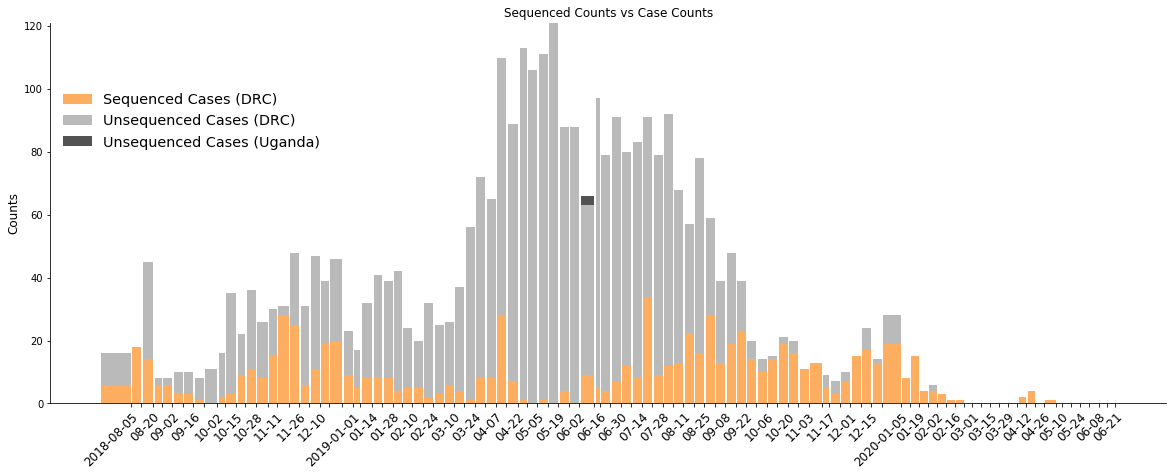

In [13]:
def plot_temporal_bar_chart(ax, title=True):
    # bar width is in units of days
    
    
    x_label = []
    y_seq = []
    y_case_additional = []
    y_case = []
    y_uganda_case = []
    width = [] # bar width varies with reporting period associated
    bar_spacing = 1 # i.e. 1 day between bars
    last_x_tick = 0
    x_bar_start_position = [0]
    x_tick_pos = []
    current_label_year = '2000'
    current_year_label_count = 0
    
    for i in range(1, len(case_counts_per_sit_rep)):
        # duration in units of days
        duration = int((numeric_date(case_counts_per_sit_rep[i]['last_day']) - numeric_date(case_counts_per_sit_rep[i-1]['last_day']))*365.25)
        y_seq.append(case_counts_per_sit_rep[i]['n_sequenced'])
        y_case.append(case_counts_per_sit_rep[i]['n_inferred'])
        y_uganda_case.append(case_counts_per_sit_rep[i]['uganda_cases'] if 'uganda_cases' in case_counts_per_sit_rep[i] else 0)
        ## work out offsets (to make stacked bar charts)
        additional_cases = case_counts_per_sit_rep[i]['n_inferred'] - case_counts_per_sit_rep[i]['n_sequenced']
        if additional_cases<0:
            print(f"Sit-rep {str(case_counts_per_sit_rep[i]['sit_rep'])} had more sequences {case_counts_per_sit_rep[i]['n_sequenced']} than cases {case_counts_per_sit_rep[i]['n_inferred']}")
            y_case_additional.append(0)
        else:
            y_case_additional.append(additional_cases)
        width.append(duration-bar_spacing)
        
        # set the NEXT bar start position now...
        x_bar_start_position.append(x_bar_start_position[-1]+duration)
        
        # set the x tick position (we want the label at the RHS of the bar)
        if len(x_tick_pos):
            x_tick_pos.append(x_tick_pos[-1]+duration)
        else:
            x_tick_pos.append(0+duration-bar_spacing)
        
#         x_tick_pos.append(x_tick_pos[-1]+duration)
        label = case_counts_per_sit_rep[i]['last_day']
        if label[0:4]==current_label_year:
            current_year_label_count += 1
            if current_year_label_count%2:
                 x_label.append('')
            else:
                x_label.append(label[5:])

        else:
            if len(x_label):
                x_label[-1]='' # clear previous label for space reasons
            x_label.append(label)
            current_label_year=label[0:4]
            current_year_label_count = 0
        

    x_bar_start_position = x_bar_start_position[:-1] # drop last bar start (since there's no next bar!)

    # plotting order: first, sequences, then add on additional cases, then add on 
    ax.bar(x_bar_start_position, y_seq, color="#fdae61", label="Sequenced Cases (DRC)", width=width, align='edge')
    ax.bar(x_bar_start_position, y_case_additional, color="#bababa", label="Unsequenced Cases (DRC)", bottom=y_seq, width=width, align='edge')
    ax.bar(x_bar_start_position, y_uganda_case, color="#525252", bottom=y_case, label="Unsequenced Cases (Uganda)", width=width, align='edge')

    
    if title:
        ax.set_title("Sequenced Counts vs Case Counts")
    ax.set_ylabel('Counts', fontsize='large')
    ax.set_xticks(x_tick_pos)
    ax.set_xticklabels(
        x_label,
        rotation=45, ha="right", fontsize='large', rotation_mode="anchor"
    )
     # ax.set_yticklabels(ax.get_yticklabels(), fontsize='large')
    ## modify y labels to use fontsize=large
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 0.85), fontsize='x-large', frameon=False)
    
    ## LINEAR REGRESSION
    lr = stats.linregress(y_seq, y_case)
    print("Correlation between sampling & cases, per epi week, r^2:", lr.rvalue**2)
    

fig, ax = plt.subplots(figsize=(20, 7))
plot_temporal_bar_chart(ax)
plt.show()



## Plot the correlation between sequences & cases in each Health Zone

MISSING COLOUR FOR HZ Pinga
Correlation between sampling & cases per HZ, r^2: 0.928904544783788


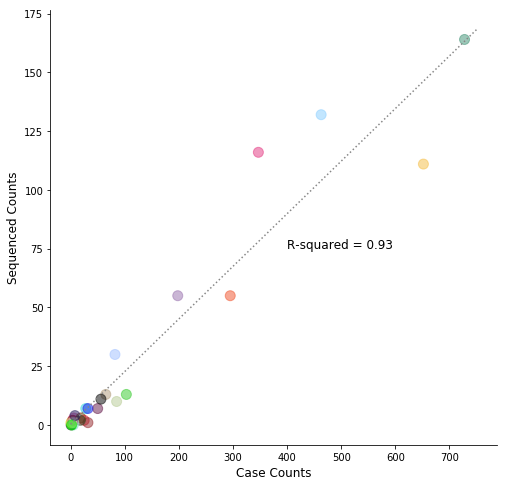

In [14]:
def plot_hz_scatter(ax, s=100):
    
    hzs = list(case_counts_per_hz.keys())

    x = np.array([case_counts_per_hz[hz] if hz in case_counts_per_hz else 0 for hz in hzs])
    y = np.array([sample_counts_per_hz[hz] if hz in sample_counts_per_hz else 0 for hz in hzs])
    c = np.array([get_health_zone_colour(hz) for hz in hzs])
    plt.scatter(x, y, s=s, c=c, alpha=0.5)
    
    
    ax.set_xlabel('Case Counts', fontsize='large')
    ax.set_ylabel('Sequenced Counts', fontsize='large')
    
    # plot overlay of the linear regression
    linreg = stats.linregress(x, y)
    print("Correlation between sampling & cases per HZ, r^2:", linreg.rvalue**2)
    plt.plot([0, 750], [linreg.intercept, 750*linreg.slope], linestyle=':', color="#878787")
    plt.text(400, 75, 'R-squared = %0.2f' % linreg.rvalue**2, fontsize='large')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

fig, ax = plt.subplots(figsize=(8,8))
plot_hz_scatter(ax)
plt.show()



# We're interested in the change in lag time (sample -> actionable result) pre & post Sept 1

The changes include more reagents, more training and using nextstrain.

What is the difference between **pre** and **post**?

* For sequencing analysis, it's based on the sample date
* For release it's based on the sequencing date

This is deisgned to best reflect realit -- for instance, if something was sequenced after sept 1st, then the release of that data is considered "post". In truth, the "sequencing" of that data is a mixture of pre and post.


# TODO -- how to handle cases where we've (deliberately) retrospectively sequenced?!?


Problem! Sample BEN9397 sequenced (2019-02-17) before it was sampled (2019-02-25)
Problem! Sample BEN340 hap map (2018-11-25) before it was sequenced (2019-01-11)
Problem! Sample BEN1271 hap map (2018-11-25) before it was sequenced (2019-01-11)
Problem! Sample BEN1656 hap map (2018-11-25) before it was sequenced (2019-01-08)
Problem! Sample BTB675 hap map (2018-11-25) before it was sequenced (2018-12-29)
Problem! Sample BTB701 hap map (2018-11-25) before it was sequenced (2018-12-29)
Problem! Sample BTB725 hap map (2018-11-25) before it was sequenced (2018-12-29)
Problem! Sample BEN2010 hap map (2018-11-25) before it was sequenced (2019-01-08)
Problem! Sample BEN2024 hap map (2018-11-25) before it was sequenced (2019-01-08)
Problem! Sample BTB755 hap map (2018-11-25) before it was sequenced (2018-12-29)
Problem! Sample BTB766 hap map (2018-11-25) before it was sequenced (2018-12-29)
Problem! Sample BEN2030 hap map (2018-11-25) before it was sequenced (2019-01-08)
Problem! Sample BEN206

/Users/naboo/miniconda3/envs/augur/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


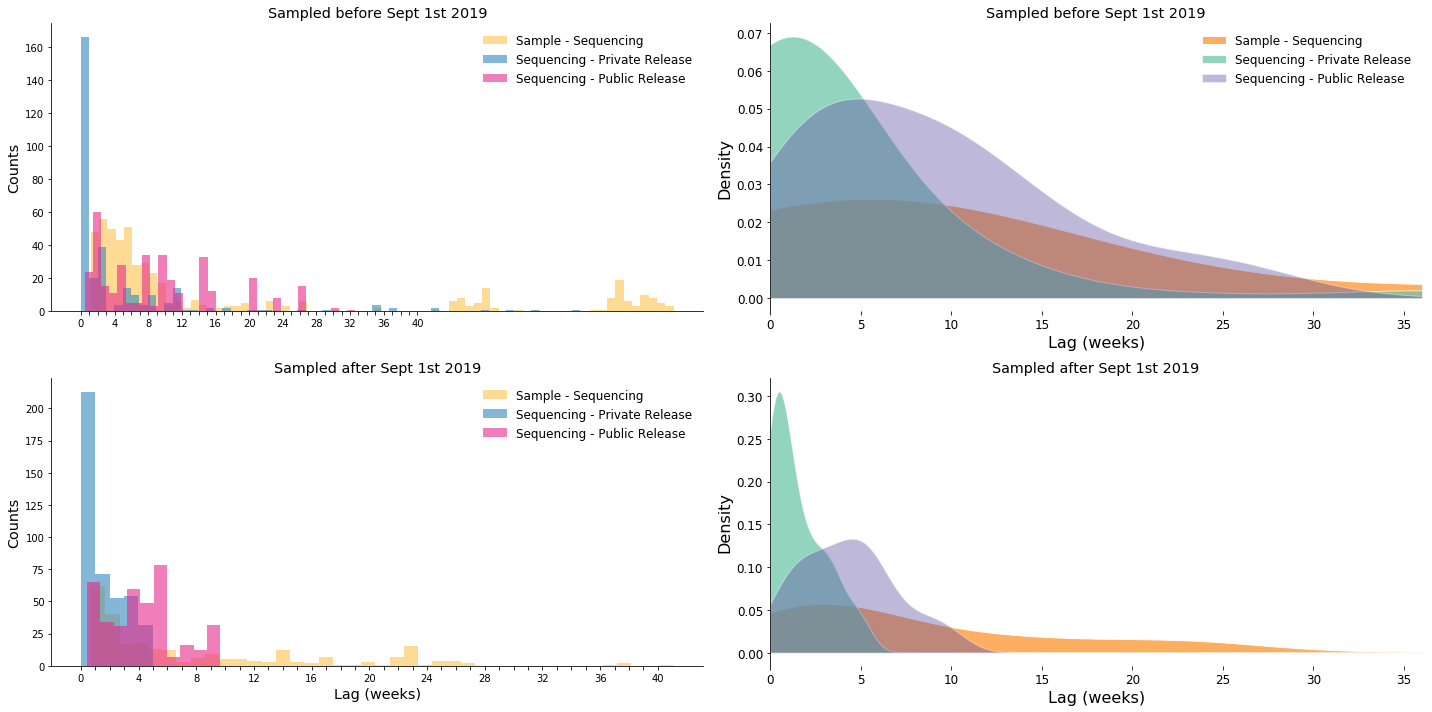

In [15]:
import math

def get_lag_data():
    """Parse `data` to analyse lag times"""
    lags = {}
    trip_date = numeric_date("2019-09-01") # We don't actually say "trip date" in the paper, rather we're specific about sept 1st
    lags['trip_date'] = trip_date
    
    # Sequencing lags are the time between sample and sequencing. Note the potential bias if we go back and sequence historical isolates!
    
    lags['sequencing_pre'] = [] # defined as samples collected before sept 1st
    lags['sequencing_post'] = []
    for d in [dd for dd in data if dd["sample_date_num"] and dd["sequenced_num"]]:
        lag = d["sequenced_num"] - d["sample_date_num"]
        if lag < 0:
            print(f"Problem! Sample {d['name']} sequenced ({d['sequenced']}) before it was sampled ({d['sample_date']})")
        else:
            lags['sequencing_pre'].append(lag) if d["sample_date_num"]<trip_date else lags['sequencing_post'].append(lag)

    # we define private release as hap-map or private nextstrain, whatever came first
    lags['private_release_pre'] = []
    lags['private_release_post'] = []
    for d in data:
        if not d["sequenced_num"] or not d["sample_date_num"] or not (d["private_nextstrain_release_num"] or d["hap_map_release_num"]):
            continue
        hap_map_lag = d["hap_map_release_num"] - d["sequenced_num"] if d["hap_map_release_num"] else 10000000
        nextstrain_lag = d["private_nextstrain_release_num"] - d["sequenced_num"] if d["private_nextstrain_release_num"] else 10000000
        lag = min([hap_map_lag, nextstrain_lag])
        if lag < 0:
            if hap_map_lag < nextstrain_lag:
                print(f"Problem! Sample {d['name']} hap map ({d['hap_map_release']}) before it was sequenced ({d['sequenced']})")
            else:
                print(f"Problem! Sample {d['name']} private nextstrain release ({d['private_nextstrain_release']}) before it was sequenced ({d['sequenced']})")
        else:
            lags['private_release_pre'].append(lag) if d["sequenced_num"]<trip_date else lags['private_release_post'].append(lag)
    
    lags['public_release_pre'] = []
    lags['public_release_post'] = []
    for d in [dd for dd in data if dd["sequenced_num"] and dd["public_nextstrain_release_num"] and dd["sample_date_num"]]:
        lag = d["public_nextstrain_release_num"] - d["sequenced_num"]
        if lag < 0:
            print(f"Problem! Sample {d['name']} public nextstrain release ({d['public_nextstrain_release']}) before it was sequenced ({d['sequenced']})") 
        else:
            lags['public_release_pre'].append(lag) if d["sequenced_num"]<trip_date else lags['public_release_post'].append(lag)
    return lags


def plot_lag_histograms(lags, axpre, axpost):
    """plot histograms of lags on ax1 (pre) and ax2 (post)"""
    
    def get_bin_num(d):
        # want each histogram bin to represent ~1 week
        return math.ceil( (max(d) - min(d)) / (1/52) )
    
    colours = ["#fec44f", "#3288bd", "#e7298a"]
    N, bins, patches = axpre.hist(lags['sequencing_pre'], bins=get_bin_num(lags['sequencing_pre']), density=False, alpha=0.6, color=colours[0], label="Sample - Sequencing")
    N, bins, patches = axpre.hist(lags['private_release_pre'], bins=get_bin_num(lags['private_release_pre']), density=False, alpha=0.6, color=colours[1], label="Sequencing - Private Release")
    N, bins, patches = axpre.hist(lags['public_release_pre'], bins=get_bin_num(lags['public_release_pre']), density=False, alpha=0.6, color=colours[2], label="Sequencing - Public Release")

    N, bins, patches = axpost.hist(lags['sequencing_post'], bins=get_bin_num(lags['sequencing_post']), density=False, alpha=0.6, color=colours[0], label="Sample - Sequencing")
    N, bins, patches = axpost.hist(lags['private_release_post'], bins=get_bin_num(lags['private_release_post']), density=False, alpha=0.6, color=colours[1], label="Sequencing - Private Release")
    N, bins, patches = axpost.hist(lags['public_release_post'], bins=get_bin_num(lags['public_release_post']), density=False, alpha=0.6, color=colours[2], label="Sequencing - Public Release")

    axpre.legend(loc='upper right', fontsize='large', frameon=False)
    axpost.legend(loc='upper right', fontsize='large', frameon=False)

    axpre.set_title("Sampled before Sept 1st 2019", fontsize='x-large')
    axpost.set_title("Sampled after Sept 1st 2019", fontsize='x-large')

    axpost.set_xlabel('Lag (weeks)', fontsize='x-large')
    
    for ax in [axpre, axpost]:
        weeks = [x for x in range(0, 41)]
        ax.set_xticks(np.array([x/52 for x in weeks]))
        ax.set_xticklabels(np.array(['' if x%4 else x for x in weeks]))
        ax.set_ylabel('Counts', fontsize='x-large')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        
def plot_lag_kernels(lags, axpre, axpost, title=True):
    """plot KDEs of lags on ax1 (pre) and ax2 (post)"""

    def get_kernel(x_grid, lag_data):
        kde = stats.gaussian_kde(lag_data, bw_method=0.5) 
        y_grid=kde.evaluate(x_grid)
        asymptote=kde.integrate_box_1d(0.0,max(x_grid)) ## due to high bandwidth of KDE it's necessary to renormalize the integral to be between 0.0 and 1.0
        integral=[kde.integrate_box_1d(0.0,x)/asymptote for x in x_grid] ## get normalized integral
        idx50=integral.index(sorted(integral,key=lambda x:abs(x-0.5))[0]) ## identify slice closest to 0.5
        idx95=integral.index(sorted(integral,key=lambda x:abs(x-0.95))[0]) ## identify slice closest to 0.95
        print("\t50%:", x_grid[idx50], "95%", x_grid[idx95])
        return {"kde": kde, "idx50": idx50, "idx95": idx95, "x_grid": x_grid, "y_grid": y_grid}

    
    def plot_individual_kernel(ax, kernel, c, label, alpha):
        idx50=kernel["idx50"]; idx95=kernel["idx95"]; x_grid=kernel["x_grid"]; y_grid=kernel["y_grid"]
        ax.fill_between(x_grid,      y_grid,      facecolor=c, edgecolor='w', lw=1, alpha=alpha, label=label) ## plot pdf 
        # Prettify
        ax.tick_params(axis='x',labelsize=12,direction='out')
        ax.tick_params(axis='y',labelsize=12,direction='out')
        ax.yaxis.tick_left()
        ax.xaxis.tick_bottom()
        ax.set_xlim(x_grid[0], x_grid[-1])
        for pos in ["top", "right", "bottom"]:
            ax.spines[pos].set_visible(False)
        ax.set_ylabel('Density',size=16)
        ax.set_xlabel('Lag (weeks)',size=16)

        
    def convert_to_weeks(data):
        return [d*52 for d in data]

    seq_lag = [convert_to_weeks(lags['sequencing_pre']), convert_to_weeks(lags['sequencing_post'])]
    private_release = [convert_to_weeks(lags['private_release_pre']), convert_to_weeks(lags['private_release_post'])]
    public_release = [convert_to_weeks(lags['public_release_pre']), convert_to_weeks(lags['public_release_post'])]
    
    seq_lag_kernels = [get_kernel(np.linspace(0.0, 36.0, 361), x) for x in seq_lag]
    private_release_kernels = [get_kernel(np.linspace(0.0, 36.0, 361), x) for x in private_release]
    public_release_kernels = [get_kernel(np.linspace(0.0, 36.0, 361), x) for x in public_release]
    
    ## Plot
    for idx, ax in enumerate([axpre, axpost]):
        plot_individual_kernel(ax, seq_lag_kernels[idx], "#fdae61", "Sample - Sequencing", alpha=1)
        plot_individual_kernel(ax, private_release_kernels[idx], "#66c2a5", "Sequencing - Private Release", alpha=0.7)
        plot_individual_kernel(ax, public_release_kernels[idx], "#5e4fa2", "Sequencing - Public Release", alpha=0.4)

    if title:
        axpre.set_title("Sampled before Sept 1st 2019", fontsize='x-large')
        axpost.set_title("Sampled after Sept 1st 2019", fontsize='x-large')

    axpre.legend(loc='upper right', fontsize='large', frameon=False)
#     axpost.legend(loc='upper right', fontsize='large', frameon=False)
    

def summarise_lags(lags):
    
    def nDays(n):
        return "{:.2f}".format(n*365.25)
    def stats(txt, d):
        mean = nDays(np.mean(d))
        stdev = nDays(np.std(d))
        display(txt, mean, stdev)
    def display(txt, a, b):
        print("{: <30} {: <6} {: <6}".format(txt, a, b))

    pub_priv_lag = [d["public_nextstrain_release_num"]-d["private_nextstrain_release_num"] for d in [dd for dd in data if dd["public_nextstrain_release_num"] and dd["private_nextstrain_release_num"] and dd["sample_date_num"] and dd["sample_date_num"]>lags['trip_date']]]

    display("", "mean", "stdev")
    stats("Sample-Seq", lags['sequencing_pre']+lags['sequencing_post'])
    stats("Seq-Private Release (>Sept 1)", lags['private_release_post'])
    stats("Seq-Public Release (<Sept 1)", lags['public_release_pre'])
    stats("Seq-Public Release (>Sept 1)", lags['public_release_post'])
    stats("Public-private (>Sept 1)", pub_priv_lag)
    


lags = get_lag_data()
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, tight_layout=True, figsize=(20, 10))
plot_lag_histograms(lags, ax[0][0], ax[1][0])
plot_lag_kernels(lags, ax[0][1], ax[1][1])
summarise_lags(lags)



# Make the main figure resulting from this notebook

**Figure 1: Progress of genomic surveillance over the course of the outbreak.**
(A) Total numbers of sequenced (orange) and unsequenced confirmed cases (grey) by WHO situation report. In total, 24% of confirmed cases (23% of total) have been sequenced and reported here.
(B) Correlation between the number of laboratory-confirmed cases reported in a health zone and the number sequenced cases from a health zone.
(C) Time lags between sample collection and release of phylogenetic analyses. Three colored largely-vertical lines, firstly for haplotype map release (November 2018, teal), then for public Nextstrain release (March 2019, purple), and then for private Nextstrain release (September 2019, light blue) represent the initial roll-out of each of these platforms, when all sequence data up to that date were re-released on the new platform. The analysis in this paper uses the publicly released data. Dashed black lines represent WHO declataion of outbreak start and end. 
(D, E) Kernel density estimates of lag times between sample collection and sequencing (orange), between sequencing and private release of the data (teal), and between sequencing and public release of the data (purple), prior to September 2019 (D) and after switching to privately-released Nextstrain Narrative situation reports in September 2019 (E).


Sit-rep 2 had more sequences 18 than cases 14
Sit-rep 66 had more sequences 11 than cases 10
Sit-rep 67 had more sequences 13 than cases 12
Sit-rep 71 had more sequences 15 than cases 11
Correlation between sampling & cases, per epi week, r^2: 0.07545328755964818
MISSING COLOUR FOR HZ Pinga
Correlation between sampling & cases per HZ, r^2: 0.928904544783788
Main axis bounds: 2018.5684931506848 2020.5505464480875
	50%: 11.0 95% 29.6
	50%: 7.800000000000001 95% 26.200000000000003
	50%: 4.9 95% 18.8
	50%: 1.5 95% 4.800000000000001
	50%: 9.1 95% 25.700000000000003
	50%: 4.4 95% 9.600000000000001


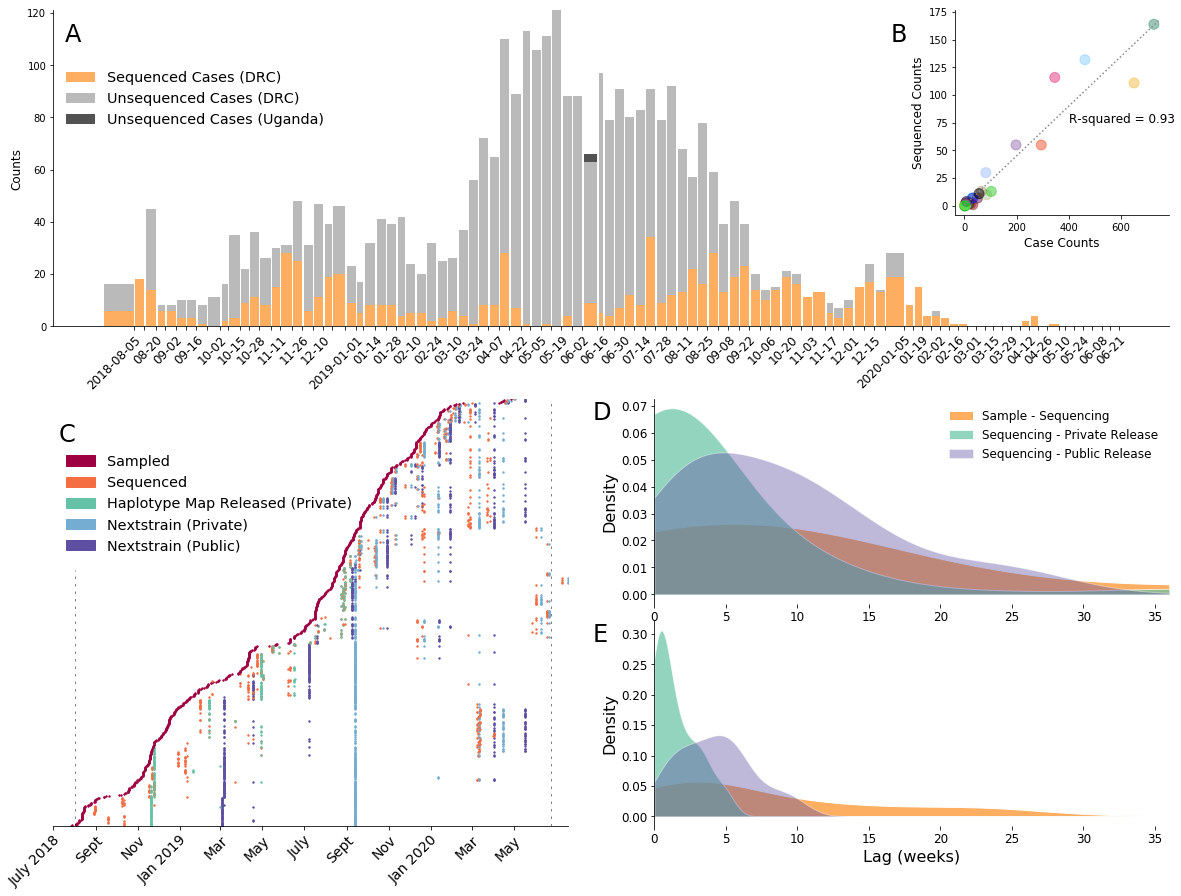

In [16]:
def draw(filename):
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(nrows=15, ncols=4, figure=fig, wspace=0.4, hspace=0.45)
    
    top_ax = fig.add_subplot(gs[:6, :])
    plot_temporal_bar_chart(top_ax, title=False)

    top_right_insert_ax = fig.add_subplot(gs[0:4, 3])
    plot_hz_scatter(top_right_insert_ax)

    bottom_left_ax = fig.add_subplot(gs[7:, 0:2])
    draw_temporal_scatter(bottom_left_ax)
    
    kernel_ax_top = fig.add_subplot(gs[7:11, 2:4])
    kernel_ax_bottom = fig.add_subplot(gs[11:, 2:4])
    plot_lag_kernels(lags, kernel_ax_top, kernel_ax_bottom, title=False)
    
    # Annotate figure labels
    top_ax.text(0.01, 0.9, 'A', size=24, color='k', weight="medium", transform=top_ax.transAxes)
    top_ax.text(0.75, 0.9, 'B', size=24, color='k', weight="medium", transform=top_ax.transAxes)
    bottom_left_ax.text(0.01, 0.9, 'C', size=24, color='k', weight="medium", transform=bottom_left_ax.transAxes)
    kernel_ax_top.text(-0.12, 0.9, 'D', size=24, color='k', weight="medium", transform=kernel_ax_top.transAxes)
    kernel_ax_bottom.text(-0.12, 0.9, 'E', size=24, color='k', weight="medium", transform=kernel_ax_bottom.transAxes)

    if filename:
        plt.savefig(filename, format="png", pad_inches=0)
    plt.show()
    
draw(filename="Figure1.png")